# MMSegmentation Tutorial
Welcome to MMSegmentation!

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results.

In [1]:
cd mmsegmentation

/home/test/carasml/segmentation/Mask2former/mmsegmentation


/home/test/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Finetune a semantic segmentation model on a new dataset

To finetune on a customized dataset, the following steps are necessary.
1. Add a new dataset class.
2. Create a config file accordingly.
3. Perform training and evaluation.

Download dataset from https://challenge.isic-archive.com/data/#2018 <br>
We use task 1 training and validation dataset, so there will be 4 zips <br>
Including : <br>
&nbsp;&nbsp;&nbsp;&nbsp;Training Data (10.4GB): https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip <br>
&nbsp;&nbsp;&nbsp;&nbsp;Training Ground Truth (26MB): https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip <br>
&nbsp;&nbsp;&nbsp;&nbsp;Validation Data (228MB): https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip <br>
&nbsp;&nbsp;&nbsp;&nbsp;Validation Ground Truth (742KB): https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Validation_GroundTruth.zip <br>
The ground truth are in masks of black and white<br>
 <br>
Reorder the dataset into below architecture, and place it under the folder 'mmsegmentation'  <br>

In [ ]:
'''
ISIC/ 
├── images/ 
│   ├── training/ (rename from ISIC2018_Task1-2_Training_Input)
│   │   ├── 1.jpg 
│   │   ├── 2.jpg 
│   │   └── ... 
│   └── validation/ (rename from ISIC2018_Task1-2_Validation_Input)
│       └── ... 
└── annotations/ 
    ├── training/ (rename from ISIC2018_Task1_Training_GroundTruth)
    │   ├── 1.png 
    │   ├── 2.png 
    │   └── ... 
    └── validation/ (rename from ISIC2018_Task1_Validation_GroundTruth)
        └── ... 
'''

In [16]:
# convert to format that mmseg recognise
# we assign value = 0 as background, value = 1 as class 1 which is lesion
import os
import cv2
import numpy as np

mask_dir = 'ISIC/annotations/training'

for mask_file in os.listdir(mask_dir):
    if mask_file.endswith('.png'):
        mask_path = os.path.join(mask_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        #mask[mask == 0] = 0
        mask[mask == 255] = 1
        cv2.imwrite(mask_path, mask)
        print(f"Processed {mask_file}")

mask_dir = 'ISIC/annotations/validation'

for mask_file in os.listdir(mask_dir):
    if mask_file.endswith('.png'):
        mask_path = os.path.join(mask_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        #mask[mask == 0] = 0
        mask[mask == 255] = 1
        cv2.imwrite(mask_path, mask)
        print(f"Processed {mask_file}")


Processed ISIC_0000143_segmentation.png
Processed ISIC_0001385_segmentation.png
Processed ISIC_0012836_segmentation.png
Processed ISIC_0012722_segmentation.png
Processed ISIC_0012348_segmentation.png
Processed ISIC_0013034_segmentation.png
Processed ISIC_0014983_segmentation.png
Processed ISIC_0008528_segmentation.png
Processed ISIC_0015311_segmentation.png
Processed ISIC_0012828_segmentation.png
Processed ISIC_0013390_segmentation.png
Processed ISIC_0001449_segmentation.png
Processed ISIC_0014357_segmentation.png
Processed ISIC_0014166_segmentation.png
Processed ISIC_0000259_segmentation.png
Processed ISIC_0014284_segmentation.png
Processed ISIC_0012324_segmentation.png
Processed ISIC_0012510_segmentation.png
Processed ISIC_0012518_segmentation.png
Processed ISIC_0000268_segmentation.png
Processed ISIC_0015962_segmentation.png
Processed ISIC_0012369_segmentation.png
Processed ISIC_0000054_segmentation.png
Processed ISIC_0009564_segmentation.png
Processed ISIC_0014511_segmentation.png


In [3]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir ./checkpoint
!mkdir ./output

In [5]:
!mim download mmsegmentation --config mask2former_r50_8xb2-160k_ade20k-512x512 --dest ./checkpoint

processing mask2former_r50_8xb2-160k_ade20k-512x512...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 MiB 10.8 MB/s eta 0:00:00m eta 0:00:010:00:01
Successfully downloaded mask2former_r50_8xb2-160k_ade20k-512x512_20221204_000055-2d1f55f1.pth to /home/test/carasml/segmentation/Mask2former/mmsegmentation/checkpoint
Successfully dumped mask2former_r50_8xb2-160k_ade20k-512x512.py to /home/test/carasml/segmentation/Mask2former/mmsegmentation/checkpoint


In [2]:
# create a mydataset data format
config = """
from mmseg.registry import DATASETS
from .basesegdataset import BaseSegDataset

@DATASETS.register_module() 
class mydataset(BaseSegDataset):
    METAINFO = {
        'classes': ['background','lesion'], # first one is background, and second and so on are our classes
        'palette': [[0, 0, 0], [0, 255, 0]], # assign color to visualize
    } 
    def __init__(self, **kwargs): 
        super(mydataset, self).__init__( 
            img_suffix='.jpg', # suffix of image
            seg_map_suffix='_segmentation.png', # suffix of segmentation annotation
            reduce_zero_label=False, 
            **kwargs) 
"""
# here we create the config file
with open('./mmseg/datasets/mydataset.py', 'w') as f:
    f.write(config)

In [3]:
# add mydataset to dataset format. after running this, reload the kernal
config = """
# Copyright (c) OpenMMLab. All rights reserved.
# yapf: disable
from .ade import ADE20KDataset
from .basesegdataset import BaseCDDataset, BaseSegDataset
from .bdd100k import BDD100KDataset
from .chase_db1 import ChaseDB1Dataset
from .cityscapes import CityscapesDataset
from .coco_stuff import COCOStuffDataset
from .dark_zurich import DarkZurichDataset
from .dataset_wrappers import MultiImageMixDataset
from .decathlon import DecathlonDataset
from .drive import DRIVEDataset
from .dsdl import DSDLSegDataset
from .hrf import HRFDataset
from .isaid import iSAIDDataset
from .isprs import ISPRSDataset
from .levir import LEVIRCDDataset
from .lip import LIPDataset
from .loveda import LoveDADataset
from .mapillary import MapillaryDataset_v1, MapillaryDataset_v2
from .night_driving import NightDrivingDataset
from .nyu import NYUDataset
from .pascal_context import PascalContextDataset, PascalContextDataset59
from .potsdam import PotsdamDataset
from .refuge import REFUGEDataset
from .stare import STAREDataset
from .synapse import SynapseDataset
from .mydataset import mydataset # register mydataset
# yapf: disable
from .transforms import (CLAHE, AdjustGamma, Albu, BioMedical3DPad,
                         BioMedical3DRandomCrop, BioMedical3DRandomFlip,
                         BioMedicalGaussianBlur, BioMedicalGaussianNoise,
                         BioMedicalRandomGamma, ConcatCDInput, GenerateEdge,
                         LoadAnnotations, LoadBiomedicalAnnotation,
                         LoadBiomedicalData, LoadBiomedicalImageFromFile,
                         LoadImageFromNDArray, LoadMultipleRSImageFromFile,
                         LoadSingleRSImageFromFile, PackSegInputs,
                         PhotoMetricDistortion, RandomCrop, RandomCutOut,
                         RandomMosaic, RandomRotate, RandomRotFlip, Rerange,
                         ResizeShortestEdge, ResizeToMultiple, RGB2Gray,
                         SegRescale)
from .voc import PascalVOCDataset

# yapf: enable
__all__ = [
    'BaseSegDataset', 'BioMedical3DRandomCrop', 'BioMedical3DRandomFlip',
    'CityscapesDataset', 'PascalVOCDataset', 'ADE20KDataset',
    'PascalContextDataset', 'PascalContextDataset59', 'ChaseDB1Dataset',
    'DRIVEDataset', 'HRFDataset', 'STAREDataset', 'DarkZurichDataset',
    'NightDrivingDataset', 'COCOStuffDataset', 'LoveDADataset',
    'MultiImageMixDataset', 'iSAIDDataset', 'ISPRSDataset', 'PotsdamDataset',
    'LoadAnnotations', 'RandomCrop', 'SegRescale', 'PhotoMetricDistortion',
    'RandomRotate', 'AdjustGamma', 'CLAHE', 'Rerange', 'RGB2Gray',
    'RandomCutOut', 'RandomMosaic', 'PackSegInputs', 'ResizeToMultiple',
    'LoadImageFromNDArray', 'LoadBiomedicalImageFromFile',
    'LoadBiomedicalAnnotation', 'LoadBiomedicalData', 'GenerateEdge',
    'DecathlonDataset', 'LIPDataset', 'ResizeShortestEdge',
    'BioMedicalGaussianNoise', 'BioMedicalGaussianBlur',
    'BioMedicalRandomGamma', 'BioMedical3DPad', 'RandomRotFlip',
    'SynapseDataset', 'REFUGEDataset', 'MapillaryDataset_v1',
    'MapillaryDataset_v2', 'Albu', 'LEVIRCDDataset',
    'LoadMultipleRSImageFromFile', 'LoadSingleRSImageFromFile',
    'ConcatCDInput', 'BaseCDDataset', 'DSDLSegDataset', 'BDD100KDataset',
    'NYUDataset', 'mydataset' # register mydataset
]
"""
# here we create the config file, you may rename it
with open('./mmseg/datasets/__init__.py', 'w') as f:
    f.write(config)

In [10]:
from mmengine import Config
cfg = Config.fromfile('configs/mask2former/mask2former_r50_8xb2-160k_ade20k-512x512.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
auto_scale_lr = dict(base_batch_size=16, enable=False)
crop_size = (
    512,
    512,
)
custom_imports = dict(allow_failed_imports=False, imports='mmdet.models')
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    test_cfg=dict(size_divisor=32),
    type='SegDataPreProcessor')
data_root = 'data/ade/ADEChallengeData2016'
dataset_type = 'ADE20KDataset'
default_hooks = dict(
    checkpoint=dict(
        by_epoch=False, interval=5000, save_best='mIoU',
        type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
e

In [11]:
# for configs explanation, you can refer to
# https://mmsegmentation.readthedocs.io/en/latest/user_guides/1_config.html
# for more augmentation, you can refer to
# https://mmsegmentation.readthedocs.io/en/latest/advanced_guides/transforms.html
import cv2

cfg.num_classes = 2 # background + 1 class
cfg.model.decode_head.num_classes = 2 
cfg.model.decode_head.loss_cls.class_weight = [1,1,0] # num_class + 1 (the extra one is for something else, may set to 0.1)
cfg.data_root = 'ISIC'
cfg.dataset_type = 'mydataset'
cfg.load_from = './checkpoint/mask2former_r50_8xb2-160k_ade20k-512x512_20221204_000055-2d1f55f1.pth'

cfg.train_dataloader.dataset.data_root='ISIC'
cfg.train_dataloader.dataset.type='mydataset'
cfg.train_dataloader.dataset.pipeline[1].reduce_zero_label = False
cfg.train_pipeline[1].reduce_zero_label = False
cfg.train_dataloader.batch_size = 4

cfg.test_dataloader.dataset.data_root='ISIC'
cfg.test_dataloader.dataset.type='mydataset'
cfg.test_dataloader.dataset.pipeline[2].reduce_zero_label = False
cfg.test_pipeline[2].reduce_zero_label = False

cfg.val_dataloader = cfg.test_dataloader
cfg.param_scheduler[0].end = int(cfg.param_scheduler[0].end/5)
cfg.train_cfg.max_iters = int(cfg.train_cfg.max_iters/5)
cfg.train_cfg.val_interval = int(cfg.train_cfg.val_interval/5)
cfg.optim_wrapper.optimizer.lr = 0.0001/16
cfg.optimizer.lr = 0.0001/16

cfg.work_dir = './work_dirs'

add_aug = dict(
    type='Albu',
    transforms=[
        dict(
            type='Affine',
            scale=(0.8, 1.1),  
            translate_percent=(-0.05, 0.05),
            rotate=(-180, 180), 
            interpolation=1,
            border_mode=cv2.BORDER_REFLECT_101,
            p=0.5),
        dict(
            type='OneOf',
            transforms=[
                dict(type='HueSaturationValue', p=1.0,
                    hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10
                ),
                dict(type='RandomBrightnessContrast', p=1.0,
                    brightness_limit=0.1, contrast_limit=0.1 
                ),
            ],
            p=0.5,
        ),
        dict(
            type='OneOf',
            transforms=[
                dict(type='ElasticTransform', border_mode=cv2.BORDER_REFLECT_101, p=1.0),
                dict(type='GridDistortion', border_mode=cv2.BORDER_REFLECT_101, p=1.0),
            ],
            p=0.5),
    ],
    keymap={
        'img': 'image',
        'gt_seg_map': 'mask',
    },
)
pre = dict(type='ConvertMaskForAlbu',num_classes=8)
post = dict(type='ConvertMaskFromAlbu')

# Find PackInputs index and insert before it
for i, transform in enumerate(cfg.train_pipeline):
    if transform['type'] == 'PackSegInputs':
        cfg.train_pipeline.insert(i, post)
        cfg.train_pipeline.insert(i, add_aug)
        cfg.train_pipeline.insert(i, pre)
        break
cfg.train_pipeline[-1].meta_keys = ('img_path', 'img_shape', 'img', 'gt_seg_map')
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline

print(f'Config:\n{cfg.pretty_text}')

Config:
auto_scale_lr = dict(base_batch_size=16, enable=False)
crop_size = (
    512,
    512,
)
custom_imports = dict(allow_failed_imports=False, imports='mmdet.models')
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    test_cfg=dict(size_divisor=32),
    type='SegDataPreProcessor')
data_root = 'ISIC'
dataset_type = 'mydataset'
default_hooks = dict(
    checkpoint=dict(
        by_epoch=False, interval=5000, save_best='mIoU',
        type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
embed_multi = dict(decay_mult=

In [12]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

07/02 17:01:21 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 892332615
    GPU 0: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda-12.8/
    NVCC: Cuda compilation tools, release 12.8, V12.8.93
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.7.0+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_75,co

/home/test/carasml/segmentation/Mask2former/mmengine/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


07/02 17:01:21 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
07/02 17:01:21 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

In [13]:
# start training, maske2former performance is not very stable, you may make more trials
runner.train()

/home/test/carasml/segmentation/Mask2former/mmsegmentation/mmseg/datasets/transforms/loading.py:83: UserWarning: `reduce_zero_label` will be deprecated, if you would like to ignore the zero label, please set `reduce_zero_label=True` when dataset initialized
  warnings.warn('`reduce_zero_label` will be deprecated, '


07/02 17:01:22 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr=6.25e-07
07/02 17:01:22 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:weight_decay=0.05
07/02 17:01:22 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr_mult=0.1
07/02 17:01:22 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:decay_mult=1.0
07/02 17:01:22 - mmengine - WARNING - backbone.bn1.weight is skipped since its requires_grad=False
07/02 17:01:22 - mmengine - WARNING - backbone.bn1.bias is skipped since its requires_grad=False
07/02 17:01:22 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:lr=6.25e-07
07/02 17:01:22 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:weight_decay=0.05
07/02 17:01:22 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:lr_mult=0.1
07/02 17:01:22 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:decay_mult=1.0
07/02 17:01:22 - mmengine - WA

/opt/miniconda3/envs/mask2former/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


07/02 17:01:33 - mmengine - INFO - Iter(train) [   50/32000]  base_lr: 6.2414e-06 lr: 6.2414e-07  eta: 1:39:53  time: 0.1579  data_time: 0.0090  memory: 12128  grad_norm: 863.9637  loss: 36.3697  decode.loss_cls: 0.5256  decode.loss_mask: 1.7140  decode.loss_dice: 1.1027  decode.d0.loss_cls: 1.5995  decode.d0.loss_mask: 2.1300  decode.d0.loss_dice: 1.4356  decode.d1.loss_cls: 1.1681  decode.d1.loss_mask: 1.7371  decode.d1.loss_dice: 1.1500  decode.d2.loss_cls: 0.9377  decode.d2.loss_mask: 1.6881  decode.d2.loss_dice: 1.0914  decode.d3.loss_cls: 0.8376  decode.d3.loss_mask: 1.6378  decode.d3.loss_dice: 1.0909  decode.d4.loss_cls: 0.6875  decode.d4.loss_mask: 1.5853  decode.d4.loss_dice: 1.0463  decode.d5.loss_cls: 0.5322  decode.d5.loss_mask: 1.6583  decode.d5.loss_dice: 1.0825  decode.d6.loss_cls: 0.4967  decode.d6.loss_mask: 1.6741  decode.d6.loss_dice: 1.1072  decode.d7.loss_cls: 0.5101  decode.d7.loss_mask: 1.6868  decode.d7.loss_dice: 1.1027  decode.d8.loss_cls: 0.5140  decode.d8.l

KeyboardInterrupt: 

In [14]:
import torch
#after training/testing, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

# Test model

In [15]:
import os
import glob
# Setup a checkpoint file to load, input the location of best pth we trained
def get_best_checkpoint(base_dir):
    best_ckpt = None
    latest_time = 0

    pattern = os.path.join(base_dir, "best_mIoU_iter_*.pth")
    candidates = glob.glob(pattern)

    for ckpt_path in candidates:
        mtime = os.path.getmtime(ckpt_path)
        if mtime > latest_time:
            latest_time = mtime
            best_ckpt = ckpt_path

    return best_ckpt

best_ckpt = get_best_checkpoint("work_dirs/")
print(f"Using best checkpoint: {best_ckpt}")

Using best checkpoint: work_dirs/best_mIoU_iter_22000.pth


In [16]:
%run tools/test.py work_dirs/mask2former_r50_8xb2-160k_ade20k-512x512.py {best_ckpt}

07/02 18:09:46 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 91957576
    GPU 0: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda-12.8/
    NVCC: Cuda compilation tools, release 12.8, V12.8.93
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.7.0+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_75,cod

/home/test/carasml/segmentation/Mask2former/mmengine/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


07/02 18:09:47 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
07/02 18:09:47 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/test/carasml/segmentation/Mask2former/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '
/home/test/carasml/segmentation/Mask2former/mmsegmentation/mmseg/datasets/transforms/loading.py:83: UserWarning: `reduce_zero_label` will be deprecated, if you would like to ignore the zero label, please set `reduce_zero_label=True` when dataset initialized
  warnings.warn('`reduce_zero_label` will be deprecated, '


07/02 18:09:47 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
Loads checkpoint by local backend from path: work_dirs/best_mIoU_iter_22000.pth
07/02 18:09:47 - mmengine - INFO - Load checkpoint from work_dirs/best_mIoU_iter_22000.pth
07/02 18:09:50 - mmengine - INFO - Iter(test) [ 50/100]    eta: 0:00:02  time: 0.0224  data_time: 0.0025  memory: 6833  
07/02 18:09:52 - mmengine - INFO - Iter(test) [100/100]    eta: 0:00:00  time: 0.0297  data_time: 0.0065  memory: 5742  
07/02 18:09:52 - mmengine - INFO - per class results:
07/02 18:09:52 - mmengine - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 93.01 | 95.54 |
|   lesion   | 80.74 | 91.71 |
+------------+-------+-------+
07/02 18:09:52 - mmengine - INFO - Iter(test) [100/100]    aAcc: 94.5900  mIoU: 86.8800  mAcc: 93.6300  data_time: 0.0145  time: 0.0405


In [17]:
import torch
#after training/testing, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

# Inference on image

Loads checkpoint by local backend from path: work_dirs/best_mIoU_iter_22000.pth


/home/test/carasml/segmentation/Mask2former/mmengine/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


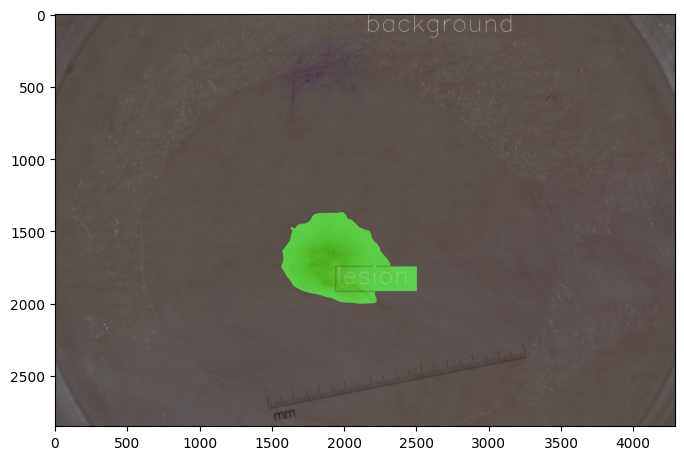

In [18]:
from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
import matplotlib.pyplot as plt
from mmengine import Config
cfg = Config.fromfile('work_dirs/mask2former_r50_8xb2-160k_ade20k-512x512.py')

# Init the model from the config and the checkpoint
checkpoint_path = best_ckpt
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('ISIC/images/validation/ISIC_0012255.jpg')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))


# Export 
Currently MMdeploy does not support exporting Mask2former to other backends yet.
If you need model to export, please refer to https://mmdeploy.readthedocs.io/en/latest/03-benchmark/supported_models.html